## Cargar los datos

In [448]:
# pip install skforecast
# !pip install keras
# !pip install tensorflow
# !pip install nltk
# nltk.download('punkt')

In [449]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense   
import nltk
import re
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
pd.options.display.max_rows = 50

In [450]:
union_datasets_forecasting = pd.read_csv("./union_datasets_forecasting.csv")

In [451]:
union_datasets_forecasting

,cod_distrito,conteo,fecha
0,3.0,9,2010-01-01
1,4.0,4,2010-01-01
2,5.0,3,2010-01-01
3,6.0,7,2010-01-01
4,7.0,2,2010-01-01
...,...,...,...
76748,3.0,9,2023-10-31
76749,2.0,6,2023-10-31
76750,1.0,5,2023-10-31
76751,10.0,8,2023-10-31


In [452]:
union_datasets_forecasting['fecha'] = pd.to_datetime(union_datasets_forecasting['fecha'], format='%Y-%m-%d')

fecha_limite = union_datasets_forecasting['fecha'].quantile(0.8)

train = union_datasets_forecasting[union_datasets_forecasting['fecha'] <= fecha_limite]
test = union_datasets_forecasting[union_datasets_forecasting['fecha'] > fecha_limite]

## Preprocesamiento del dataset

In [453]:
print("Tamaños de los datasets: ", " Entrenamiento: ",train.shape, " Prueba: ", test.shape)

Tamaños de los datasets:   Entrenamiento:  (61406, 3)  Prueba:  (15347, 3)


In [454]:
train

,cod_distrito,conteo,fecha
0,3.0,9,2010-01-01
1,4.0,4,2010-01-01
2,5.0,3,2010-01-01
3,6.0,7,2010-01-01
4,7.0,2,2010-01-01
...,...,...,...
61401,10.0,14,2021-07-19
61402,6.0,4,2021-07-19
61403,7.0,1,2021-07-19
61404,8.0,4,2021-07-19


In [455]:
def create_datasets_districts(train):
    datasets_districts = []
    for i in range(1,len(train.cod_distrito.unique())+1):
        datasets_districts.append(train[train.cod_distrito==i])
    return datasets_districts

In [456]:
datasets_distritos = create_datasets_districts(train)
for i in range(len(datasets_distritos)):
    datasets_distritos[i] = datasets_distritos[i].reset_index()
datasets_distritos[7]

,index,cod_distrito,conteo,fecha
0,16,8.0,2,2010-01-02
1,32,8.0,3,2010-01-03
2,42,8.0,3,2010-01-04
3,56,8.0,4,2010-01-05
4,72,8.0,7,2010-01-07
...,...,...,...,...
3308,61313,8.0,6,2021-07-14
3309,61329,8.0,15,2021-07-15
3310,61353,8.0,1,2021-07-16
3311,61371,8.0,1,2021-07-17


## Modelos

#### FORECASTING / SERIES TEMPORALES

In [457]:
from skforecast import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

forecaster = ForecasterAutoreg.ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state=42),
    lags=20
)

In [458]:
def accidentes_trafico_por_distrito_forecasting(datasets_distritos):
    modelos_distritos = []
    for i in range(0,len(datasets_distritos)):
        y_distrito = datasets_distritos[i].conteo
        dataset_train, dataset_test = y_distrito[:len(y_distrito)//3], y_distrito[len(y_distrito)//3:]

        forecaster.fit(y=pd.Series(dataset_train.array))
        predictions = forecaster.predict(steps=20)

        mape = mean_absolute_percentage_error(dataset_test[:20], predictions)
        print("distrito: ", i+1, "MAPE: ", mape)
        modelos_distritos.append([i+1, mape])

In [459]:
accidentes_trafico_por_distrito_forecasting(datasets_distritos)

distrito:  1 MAPE:  0.792657142857143
distrito:  2 MAPE:  0.9118672619047619
distrito:  3 MAPE:  0.8321029761904761
distrito:  4 MAPE:  0.7534775335775337
distrito:  5 MAPE:  1.5389695360195361
distrito:  6 MAPE:  1.0901488095238099
distrito:  7 MAPE:  0.6617309523809524
distrito:  8 MAPE:  0.8744071428571427
distrito:  9 MAPE:  1.1363625000000002
distrito:  10 MAPE:  0.6814878205128204
distrito:  11 MAPE:  0.6371402777777777
distrito:  12 MAPE:  0.5674690476190476
distrito:  13 MAPE:  0.49762628205128207
distrito:  14 MAPE:  0.64595
distrito:  15 MAPE:  1.4580666666666666
distrito:  16 MAPE:  0.6445619047619049
distrito:  17 MAPE:  0.5256480158730159
distrito:  18 MAPE:  0.5921107142857144
distrito:  19 MAPE:  0.5070833333333333
distrito:  20 MAPE:  0.7949222943722944
distrito:  21 MAPE:  0.433175


#### LSTM

In [460]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

def lstm_generator(dataset_train):
    generator = TimeseriesGenerator(dataset_train, dataset_train, length=20, batch_size=64,shuffle=False)

    lstm = Sequential()
    lstm.add(LSTM(50, activation='relu', input_shape=(10,1)))
    lstm.add(Dense(1))
    lstm.compile(optimizer='adam', loss='mean_squared_error')
    lstm.fit(generator, epochs=10, shuffle=False, verbose=0)
    return lstm

In [461]:
def accidentes_trafico_por_distrito_lstm(datasets_distritos):
    modelos_distritos = []
    for i in range(0,len(datasets_distritos)):
        y_distrito = datasets_distritos[i].conteo
        dataset_train, dataset_test = y_distrito[:len(y_distrito)//3], y_distrito[len(y_distrito)//3:]
        lstm = lstm_generator(dataset_train)
        predictions = lstm.predict(dataset_test[:20])
        mape = mean_absolute_percentage_error(dataset_test[:20], predictions)
        print("distrito: ", i+1, "MAPE: ", mape)
        modelos_distritos.append([i+1, mape])

In [462]:
accidentes_trafico_por_distrito_lstm(datasets_distritos)

1/1 [==============================] - 0s 85ms/step
distrito:  1 MAPE:  0.9319210038759879
1/1 [==============================] - 0s 71ms/step
distrito:  2 MAPE:  0.9602918538442324
1/1 [==============================] - 0s 69ms/step
distrito:  3 MAPE:  0.9204871656036093
1/1 [==============================] - 0s 68ms/step
distrito:  4 MAPE:  0.9745740762436181
1/1 [==============================] - 0s 68ms/step
distrito:  5 MAPE:  0.9311920174963598
1/1 [==============================] - 0s 66ms/step
distrito:  6 MAPE:  0.9046308451819989
1/1 [==============================] - 0s 71ms/step
distrito:  7 MAPE:  0.9191830756054038
1/1 [==============================] - 0s 89ms/step
distrito:  8 MAPE:  0.9422618622900476
1/1 [==============================] - 0s 75ms/step
distrito:  9 MAPE:  0.9379215133119198
1/1 [==============================] - 0s 70ms/step
distrito:  10 MAPE:  0.935070071343619
1/1 [==============================] - 0s 68ms/step
distrito:  11 MAPE:  0.959779443842255

#### Clasificacion

In [463]:
from sklearn.model_selection import train_test_split

In [464]:
accidentes_antiguo = pd.read_csv("./accidentes_antiguo.csv")
accidentes_nuevo = pd.read_csv("./accidentes_nuevo.csv")
accidentes_antiguo = accidentes_antiguo.drop(columns=["fecha"])
accidentes_nuevo = accidentes_nuevo.drop(columns=["fecha"])

In [465]:
accidentes_antiguo.dropna(inplace=True, axis=0)

In [466]:
## exploramos el dataset equilibrando mejor
for i in accidentes_antiguo.lesividad.unique():
    print("Lesividad: ",i, " Conteo: ",accidentes_antiguo[accidentes_antiguo["lesividad"]==i].shape)

Lesividad:  IL  Conteo:  (98387, 10)
Lesividad:  HL  Conteo:  (102716, 10)
Lesividad:  HG  Conteo:  (8850, 10)
Lesividad:  NO ASIGNADA  Conteo:  (11104, 10)
Lesividad:  MT  Conteo:  (275, 10)


In [467]:
for i in accidentes_antiguo.columns:
    print(i, accidentes_antiguo[i].dtype)

cod_distrito float64
dia_semana object
hora object
lesividad object
localizacion object
rango_edad object
sexo object
tipo_accidente object
tipo_persona object
tipo_vehiculo object


In [468]:
to_dummie = ["cod_distrito","dia_semana","hora","rango_edad","sexo","tipo_persona"]
text_values = ["localizacion","tipo_vehiculo","tipo_accidente"]

In [469]:
## to_dummies
accidentes_antiguo = pd.get_dummies(accidentes_antiguo, columns=to_dummie)
accidentes_nuevo = pd.get_dummies(accidentes_nuevo, columns=to_dummie)
accidentes_antiguo.drop(columns=["localizacion", "tipo_vehiculo", "tipo_accidente"], inplace=True)
accidentes_nuevo.drop(columns=["localizacion", "tipo_vehiculo", "tipo_accidente"], inplace=True)

In [470]:
# from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer
# ## text values
# def procesar_col_text(dfaccidentes,columna):
#     accidentes_localizacion = dfaccidentes[columna].to_list()
#     accidentes_localizacion = [nltk.word_tokenize(text) for text in accidentes_localizacion]
#     letras = "[a-zA-Z]+"
#     lista_ok = []
#     for localizacion in accidentes_localizacion:
#         lista_ok.append([x for x in localizacion if x not in stopwords.words('spanish') and re.compile(letras).fullmatch(x)])
#     sentences = []
#     stemmer = LancasterStemmer()
#     for frase in lista_ok:
#         words = [stemmer.stem(x) for x in frase]
#         sentences.append(words)
#     sentences = [' '.join(i) for i in sentences]
#     tfidf = TfidfVectorizer(max_features = 1000, min_df = 2, max_df = 0.6, stop_words = stopwords.words('spanish'))
#     tfidf.fit(sentences)
#     X_fin = tfidf.transform(sentences).toarray()
#     return X_fin

In [471]:
# accidentes_localizacion = accidentes_antiguo["localizacion"].to_list()
# accidentes_localizacion = [nltk.word_tokenize(text) for text in accidentes_localizacion]
# letras = "[a-zA-Z]+"
# lista_ok = []
# for localizacion in accidentes_localizacion:
#     lista_ok.append([x for x in localizacion if x not in stopwords.words('spanish') and re.compile(letras).fullmatch(x)])
# sentences = []
# stemmer = LancasterStemmer()
# for frase in lista_ok:
#     words = [stemmer.stem(x) for x in frase]
#     sentences.append(words)
# sentences = [' '.join(i) for i in sentences]
# sentences
# tfidf = TfidfVectorizer(max_features = 1000, min_df = 2, max_df = 0.6, stop_words = stopwords.words('spanish'))
# tfidf.fit(sentences)
# X_fin = tfidf.transform(sentences).toarray()

In [472]:
# np.unique(X_fin)

In [473]:
# localizacion_text

In [474]:
# localizacion_text = procesar_col_text(accidentes_antiguo, "localizacion")
# tipo_vehiculo_text = procesar_col_text(accidentes_antiguo, "tipo_vehiculo")
# tipo_accidente_text = procesar_col_text(accidentes_antiguo, "tipo_accidente")

# accidentes_antiguo.localizacion = localizacion_text
# accidentes_antiguo.tipo_vehiculo = tipo_vehiculo_text
# accidentes_antiguo.tipo_accidente = tipo_accidente_text

In [475]:
# localizacion_text = procesar_col_text(accidentes_nuevo, "localizacion")
# tipo_vehiculo_text = procesar_col_text(accidentes_nuevo, "tipo_vehiculo")
# tipo_accidente_text = procesar_col_text(accidentes_nuevo, "tipo_accidente")

# accidentes_nuevo.localizacion = localizacion_text
# accidentes_nuevo.tipo_vehiculo = tipo_vehiculo_text
# accidentes_nuevo.tipo_accidente = tipo_accidente_text

In [476]:
accidentes_antiguo_for_process = pd.DataFrame()
accidentes_antiguo_p = accidentes_antiguo.drop_duplicates().dropna()


accidentes_antiguo_for_process = accidentes_antiguo_for_process.append(accidentes_antiguo_p[accidentes_antiguo_p["lesividad"]=='HL'][:98387%300], ignore_index=True)
accidentes_antiguo_for_process = accidentes_antiguo_for_process.append(accidentes_antiguo_p[accidentes_antiguo_p["lesividad"]=='IL'][:102716%300], ignore_index=True)
accidentes_antiguo_for_process = accidentes_antiguo_for_process.append(accidentes_antiguo_p[accidentes_antiguo_p["lesividad"]=='HG'][:8850%300], ignore_index=True)
accidentes_antiguo_for_process = accidentes_antiguo_for_process.append(accidentes_antiguo_p[accidentes_antiguo_p["lesividad"]=='MT'][:275%300], ignore_index=True)
## exploramos el dataset equilibrando mejor
for i in accidentes_antiguo.lesividad.unique():
    print("Lesividad: ",i, " Conteo: ",accidentes_antiguo[accidentes_antiguo["lesividad"]==i].shape)
# (98387, 77)(102716, 77)(8850, 77)(275, 77)

Lesividad:  IL  Conteo:  (98387, 77)
Lesividad:  HL  Conteo:  (102716, 77)
Lesividad:  HG  Conteo:  (8850, 77)
Lesividad:  NO ASIGNADA  Conteo:  (11104, 77)
Lesividad:  MT  Conteo:  (275, 77)


/tmp/ipykernel_108747/4288924214.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accidentes_antiguo_for_process = accidentes_antiguo_for_process.append(accidentes_antiguo_p[accidentes_antiguo_p["lesividad"]=='HL'][:98387%300], ignore_index=True)
/tmp/ipykernel_108747/4288924214.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accidentes_antiguo_for_process = accidentes_antiguo_for_process.append(accidentes_antiguo_p[accidentes_antiguo_p["lesividad"]=='IL'][:102716%300], ignore_index=True)
/tmp/ipykernel_108747/4288924214.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accidentes_antiguo_for_process = accidentes_antiguo_for_process.append(accidentes_antiguo_p[accidentes_antiguo_p["lesividad"]=='HG'][:8850%300], ig

In [477]:
accidentes_antiguo_X, accidentes_antiguo_y = accidentes_antiguo.drop(columns="lesividad"), accidentes_antiguo.lesividad
# accidentes_antiguo_for_process
accidentes_antiguo_X_pro, accidentes_antiguo_y_pro = accidentes_antiguo_for_process.drop(columns="lesividad"), accidentes_antiguo_for_process.lesividad

In [478]:
# X_train, X_test, y_train, y_test = train_test_split(accidentes_antiguo_X, accidentes_antiguo_y, test_size=0.3, random_state=36) 
X_train_pro, X_test_pro, y_train_pro, y_test_pro = train_test_split(accidentes_antiguo_X_pro, accidentes_antiguo_y_pro, test_size=0.3, random_state=42) 
X_train, X_test, y_train, y_test = X_train_pro, X_test_pro, y_train_pro, y_test_pro 

In [479]:
## exploramos el dataset equilibrando mejor
for i in y_train.unique():
    print("Lesividad: ",i, " Conteo: ",accidentes_antiguo[accidentes_antiguo["lesividad"]==i].shape)

Lesividad:  HL  Conteo:  (102716, 77)
Lesividad:  HG  Conteo:  (8850, 77)
Lesividad:  IL  Conteo:  (98387, 77)
Lesividad:  MT  Conteo:  (275, 77)


In [503]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, bootstrap=True)
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [504]:
# from sklearn import tree
# clf = tree.DecisionTreeClassifier()
# clf.fit(X_train, y_train)

In [505]:
prediction = clf.predict(X_test)

In [506]:
X_test.shape, y_test.shape, prediction.shape

((248, 76), (248,), (248,))

In [507]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

accuracy_score(y_test, prediction) 
recall_score(y_test, prediction, average="macro")

0.3509155075934066

(248,) (248,)


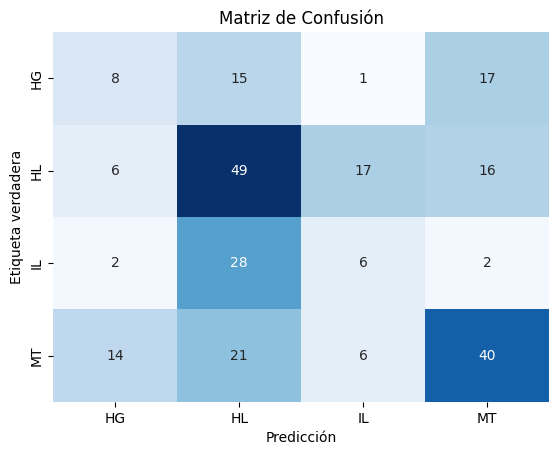

In [508]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(y_test.shape, prediction.shape)
ax= plt.subplot()
confusion_matrix = confusion_matrix(y_test, prediction)

class_labels = np.unique(prediction)

conf_matrix_df = pd.DataFrame(confusion_matrix, index=class_labels, columns=class_labels)

sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.title("Matriz de Confusión")
plt.show()

In [509]:
new_prediction = clf.predict(accidentes_nuevo)